# 6. 딥러닝을 해킹하는 적대적 공격
사람이 착시를 하듯 모델도 착시를 겪습니다. 이렇게 모델에 착시를 유도하는 공격을 적대적 공격이라고 합니다.
이번 장에서는 적대적 공격을 이해하고 방어하는 방법을 알아보겠습니다.

## 6-1. 적대적 예제 방법
적대적 예제에서의 잡음 생성 방법은 분류 기준이 무엇이냐에 따라 여러가지로 나뉩니다. 대표적인 분류기준은 다음과 같습니다.   

1. 모델 정보    
모델 정보를 알고 있으면 이를 토대로 화이트박스 방법과 모델 정보 없이 생성하는 블랙박스 방법으로 나뉩니다.   
2. 표적    
원하는 정답(모델 결과)으로 유도할 수 있는지 여부에 따라 표적 방법과 비표적 방법으로 나뉩니다.   
3. 학습   
잡음을 생성하기 위해 반복된 학습(최적화)이 필요하면 반복 아니면 원샷 방법으로 나뉩니다.   
4. 범용성   
특정 잡음이 특정 입력에만 적용 되는지 모든 이미지에 적용되는지에 따라 나뉩니다.    

기준을 잘 정해서 잡음을 생성하고 이를 모델에 테스트 해보는 것이 중요합니다. 이번엔 FGSM(Fast Gradient Sigh Method)란 방법으로 적대적 예제를 생성해 미리 학습된 딥러닝 모델을 공격해보겠습니다.

## 6-2. FGSM 공격
간단한 방식이면서도 효과적인 방법인 FGSM은 반복된 학습 없이 잡음을 생성하는 원샷 공격으로, 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성합니다.
잡음이 눈에 보이진 않아야하므로 아주 작은 숫자를 곱해서 희석한 후 원본 그림에 더하는 방식으로 잡음을 생성합니다. 
FGSM은 공격 목표를 정할 수 없는 논 타겟 방식이며 대상 모델의 정보가 필요한 화이트 박스 방식입니다.
어떻게 공격이 진행되는지 코드로 알아보겠습니다.

* 추가   
. FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하여 이를 외곡하여 모델을 속일 수 있게 하는 것 (기울기는 모델이 학습 할 때 각 필셀에 미치는 영향)   
. 모델 학습할 땐 기울기의 정반대 편으로 가중치를 조절하여 오차를 줄이지만 FGSM 공격에서는 기울기의 방향으로 입력 이미지를 조절하여 오차를 증가시키는 방향으로 조절

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

c:\Users\higi4\anaconda3\envs\env_deep3book\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\higi4\anaconda3\envs\env_deep3book\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 224, 224])
Pembroke, Pembroke Welsh corgi


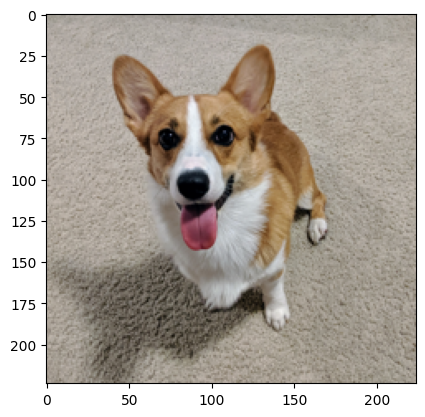

In [6]:
model = models.resnet101(pretrained=True) ## 학습된 모델 가져오기
model.eval() ## 일단 학습된 모델 성능 확인을 위해 평가모드 설정

## 0~1000까지의 레이블을 분류하도록 학습된 모델로 이 레이블이 어떤 클래스를 가르키는지 이어주는 작업
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

## 공격할 이미지 불러오기
## 학습용 데이터에 존재하지 않는 데이터 사용 => 웰시코기 사진 사용
img = Image.open('./imagenet_samples/corgie.jpg')
## 이미지들의 크기가 다양하니 224*224로 통일
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.size())

## 이미지 확인
original_img_view = img_tensor.squeeze(0).detach()
## 뒤집어진 이미지 복원 (transpose -> 차원 변경)
original_img_view = original_img_view.transpose(0, 2).transpose(0, 1).numpy()
plt.imshow(original_img_view)

output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]
prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]
print(prediction_name)
## 웰시코기 사진을 학습된 모델로 분류한 결과
## 잘 분류한걸 볼 수 있다. => 성능 좋음

whippet


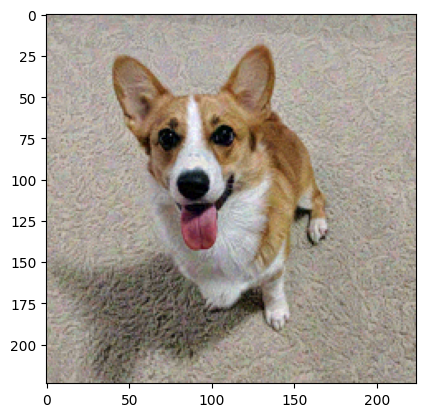

In [9]:
def fgsm_attack(image,epsilon,gradient):
    sign_gradient = gradient.sign() ## 기울기 방향성
    perturbed_image = image + epsilon * sign_gradient\
    ## 텐서의 요소가 0,1 범위를 벗어나지 않도록 조정(제한) => clamp
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

## 원본 이미지에 대한 기울기 추출을 위해 설정
img_tensor.requires_grad_(True)
output = model(img_tensor)
## nll_loss 는 negative log likelihood loss => 분류 문제에서 예측값이 레이블과 얼마나 잘 일치하는지 측정
loss = F.nll_loss(output, torch.tensor([263])) ## 웰시코기 레이블 263
model.zero_grad()
loss.backward()

gradient = img_tensor.grad.data
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

output = model(perturbed_data)
perturbed_prediction = output.max(1, keepdim=True)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]
print(perturbed_prediction_name)
## 틀림

perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0, 2).transpose(0, 1).numpy()
plt.imshow(perturbed_data_view)
## 공격된 사진 보면 실제로 눈으로 봤을땐 별다른 변화가 잘 없음